In [6]:
from torch.autograd import Variable
import torch.nn as nn
from torch.nn.functional import max_pool2d, relu, dropout, softmax
from functools import reduce
from operator import mul
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import dataloader
import os
import torch
from torch.optim import lr_scheduler
import time
import copy
import torch.optim as optim
import math

In [7]:
class AsianVanilia(nn.Module):
    
    def __init__(self, classes=10):
        super(AsianVanilia, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1, 1))
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.conv3 = nn.Conv2d(32, 32, 3)
        
        self.conv4 = nn.Conv2d(32, 64, 3, padding=(1, 1))
#         self.conv5 = nn.Conv2d(64, 64, 3, padding=(1, 1))
        self.conv6 = nn.Conv2d(64, 64, 3)
        
        self.conv7 = nn.Conv2d(64, 128, 3, padding=(1, 1))
#         self.conv8 = nn.Conv2d(128, 128, 3, padding=(1, 1))
        self.conv9 = nn.Conv2d(128, 128, 3)
        
        self.fc1 = nn.Linear(128 * 14 * 14, 1024)
#         self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(1024, classes)

        
    def forward(self, x):
        x = relu(self.conv1(x))
        x = relu(self.conv2(x))
        x = relu(self.conv3(x))
#         x = dropout(max_pool2d(x, 2))
        x = max_pool2d(x, 2)
        
        x = relu(self.conv4(x))
#         x = relu(self.conv5(x))
        x = relu(self.conv6(x))
#         x = dropout(max_pool2d(x, 2))
        x = max_pool2d(x, 2)
        
        x = relu(self.conv7(x))
#         x = relu(self.conv8(x))
        x = relu(self.conv9(x))
        x = max_pool2d(x, 2)
        
        x = x.view(-1, self.num_flat_features(x))
        x = relu(self.fc1(x))
#         x = relu(self.fc2(x))
#         x = softmax(dropout(self.fc3(x)), dim=0)
        x = softmax(self.fc3(x), dim=0)
        return x
        
    def num_flat_features(self, x):
        size = x.size()[1:]
        return reduce(mul, size)

In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
#         transforms.ColorJitter(0.1, 0.1, 0.1),
        transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(),
#         transforms.RandomRotation(10),
#         transforms.ColorJitter(0.1, 0.1, 0.1),
        transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
} 
data_dir = '../../data/AsianSampleCategory/'
image_datasets = {x: ImageFolder(os.path.join(data_dir, x), data_transforms[x]) 
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                shuffle=True, num_workers=4) for x in ['train', 'val']}
data_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
use_gpu = torch.cuda.is_available()

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = {
        'loss': {'train': [], 'val': []},
        'acc': {'train': [], 'val': []}
    }
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}:\t'.format(epoch, num_epochs - 1), end='')
#         print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
#                 scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                    model = model.cuda()
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / data_sizes[phase]
            epoch_acc = running_corrects / data_sizes[phase]
            
            history['loss'][phase].append(epoch_loss)
            history['acc'][phase].append(epoch_acc)
            print('{} Loss: {:.4f} Acc: {:.4f}\t'.format(
                phase, epoch_loss, epoch_acc), end='')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [10]:
model = AsianVanilia()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model, history = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=300)

Epoch 0/299:	train Loss: 2.3026 Acc: 0.3081	val Loss: 2.3025 Acc: 0.4400	
Epoch 1/299:	train Loss: 2.3024 Acc: 0.4343	val Loss: 2.3020 Acc: 0.2800	
Epoch 2/299:	train Loss: 2.3014 Acc: 0.4646	val Loss: 2.3000 Acc: 0.3200	
Epoch 3/299:	train Loss: 2.2979 Acc: 0.4697	val Loss: 2.2929 Acc: 0.4400	
Epoch 4/299:	train Loss: 2.2859 Acc: 0.4697	val Loss: 2.2667 Acc: 0.3600	
Epoch 5/299:	train Loss: 2.2523 Acc: 0.4949	val Loss: 2.2262 Acc: 0.2400	
Epoch 6/299:	train Loss: 2.1910 Acc: 0.4495	val Loss: 2.1714 Acc: 0.2800	
Epoch 7/299:	train Loss: 2.1305 Acc: 0.4444	val Loss: 2.1108 Acc: 0.4800	
Epoch 8/299:	train Loss: 2.1064 Acc: 0.4596	val Loss: 2.1345 Acc: 0.4000	
Epoch 9/299:	train Loss: 2.1018 Acc: 0.4848	val Loss: 2.1861 Acc: 0.3600	
Epoch 10/299:	train Loss: 2.1301 Acc: 0.4040	val Loss: 2.1607 Acc: 0.4000	
Epoch 11/299:	train Loss: 2.1039 Acc: 0.4444	val Loss: 2.1476 Acc: 0.4400	
Epoch 12/299:	train Loss: 2.0946 Acc: 0.4949	val Loss: 2.0823 Acc: 0.4400	
Epoch 13/299:	train Loss: 2.1047 Ac

Epoch 109/299:	train Loss: 2.0569 Acc: 0.6566	val Loss: 2.0631 Acc: 0.6400	
Epoch 110/299:	train Loss: 2.0524 Acc: 0.6414	val Loss: 2.0773 Acc: 0.5200	
Epoch 111/299:	train Loss: 2.0590 Acc: 0.6869	val Loss: 2.0712 Acc: 0.5600	
Epoch 112/299:	train Loss: 2.0591 Acc: 0.6768	val Loss: 2.0771 Acc: 0.6400	
Epoch 113/299:	train Loss: 2.0531 Acc: 0.6667	val Loss: 2.0604 Acc: 0.6000	
Epoch 114/299:	train Loss: 2.0613 Acc: 0.7071	val Loss: 2.0661 Acc: 0.6400	
Epoch 115/299:	train Loss: 2.0498 Acc: 0.7222	val Loss: 2.0880 Acc: 0.6000	
Epoch 116/299:	train Loss: 2.0494 Acc: 0.7121	val Loss: 2.0278 Acc: 0.6800	
Epoch 117/299:	train Loss: 2.0549 Acc: 0.6869	val Loss: 2.0459 Acc: 0.6400	
Epoch 118/299:	train Loss: 2.0735 Acc: 0.6313	val Loss: 2.0286 Acc: 0.7600	
Epoch 119/299:	train Loss: 2.0521 Acc: 0.6869	val Loss: 2.0680 Acc: 0.6000	
Epoch 120/299:	train Loss: 2.0603 Acc: 0.6667	val Loss: 2.0903 Acc: 0.5600	
Epoch 121/299:	train Loss: 2.0536 Acc: 0.7273	val Loss: 2.1036 Acc: 0.6000	
Epoch 122/29

Epoch 217/299:	train Loss: 2.0593 Acc: 0.8131	val Loss: 2.0138 Acc: 0.6800	
Epoch 218/299:	train Loss: 2.0533 Acc: 0.7626	val Loss: 2.0081 Acc: 0.6800	
Epoch 219/299:	train Loss: 2.0287 Acc: 0.8232	val Loss: 2.0136 Acc: 0.6400	
Epoch 220/299:	train Loss: 2.0440 Acc: 0.8384	val Loss: 2.0139 Acc: 0.6800	
Epoch 221/299:	train Loss: 2.0391 Acc: 0.8081	val Loss: 2.0170 Acc: 0.6400	
Epoch 222/299:	train Loss: 2.0491 Acc: 0.8030	val Loss: 2.0108 Acc: 0.7200	
Epoch 223/299:	train Loss: 2.0487 Acc: 0.7727	val Loss: 2.0044 Acc: 0.6800	
Epoch 224/299:	train Loss: 2.0385 Acc: 0.8030	val Loss: 2.0092 Acc: 0.6400	
Epoch 225/299:	train Loss: 2.0489 Acc: 0.8081	val Loss: 2.0028 Acc: 0.7200	
Epoch 226/299:	train Loss: 2.0330 Acc: 0.8485	val Loss: 2.0145 Acc: 0.7200	
Epoch 227/299:	train Loss: 2.0377 Acc: 0.8384	val Loss: 2.0383 Acc: 0.6800	
Epoch 228/299:	train Loss: 2.0432 Acc: 0.8131	val Loss: 2.0329 Acc: 0.6000	
Epoch 229/299:	train Loss: 2.0447 Acc: 0.8131	val Loss: 2.0097 Acc: 0.7600	
Epoch 230/29

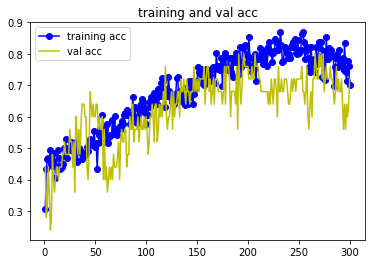

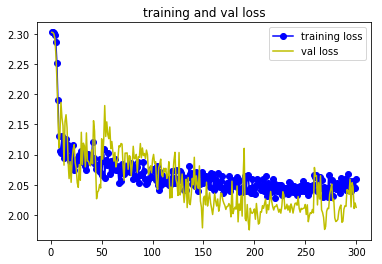

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt

train_acc = history['acc']['train']
val_acc = history['acc']['val']
train_loss = history['loss']['train']
val_loss = history['loss']['val']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'bo-', label='training acc')
plt.plot(epochs, val_acc, 'y', label='val acc')
plt.title('training and val acc')
plt.legend()

plt.figure()

plt.plot(epochs, train_loss, 'bo-', label='training loss')
plt.plot(epochs, val_loss, 'y', label='val loss')
plt.title('training and val loss')
plt.legend()

plt.show()

In [12]:
torch.save(model, 'vanilla_pytorch.pkl')

/home/jxd/anaconda3/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type AsianVanilia. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [13]:
import json
import codecs

with codecs.open('vanilla_v1.json', 'w', 'utf-8') as f:
    json.dump(history, f, ensure_ascii=False)
    f.write('\n')